# Import

In [44]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import random

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 5

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import Dataset

In [ ]:
# Step 1: Load the CSV
df = pd.read_csv("../../petfinder-pawpularity/petfinder-pawpularity-score/train.csv")  # Path to the CSV file

# Step 2: Set base folder
base_path = "../../petfinder-pawpularity/petfinder-pawpularity-score/train/"  # Base path for images

# Step 3: Prepare image paths and labels
image_paths = [os.path.join(base_path, f"{id}.jpg") for id in df['Id']]
labels = (df['Pawpularity'] * num_classes // 101).astype(int).tolist()
image_paths = image_paths[:100]  # Limit to 1000 samples for testing

# Dataset class
class PetFinderDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=66),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard ImageNet normalization
])

# Create dataset and dataloader
train_dataset = PetFinderDataset(image_paths=image_paths, labels=labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Creating CNN

In [8]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    # Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dynamically calculate the flattened size
        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flattened_size(self):
        # Pass a dummy input through the conv layers to calculate the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image
            x = self.conv_layer1(dummy_input)
            x = self.conv_layer2(x)
            x = self.max_pool1(x)
            x = self.conv_layer3(x)
            x = self.conv_layer4(x)
            x = self.max_pool2(x)
            return x.numel()

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# HyperParameters

In [22]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# total_step = len(train_loader)

# Training

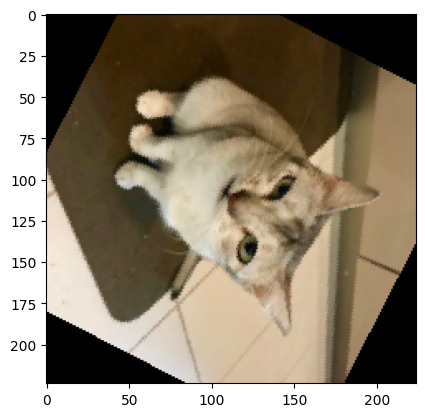

Epoch [1/5], Loss: 1.7383


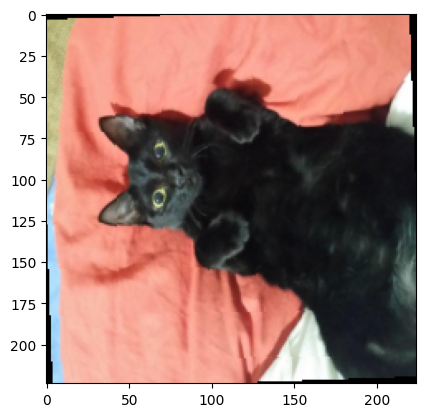

Epoch [2/5], Loss: 2.1558


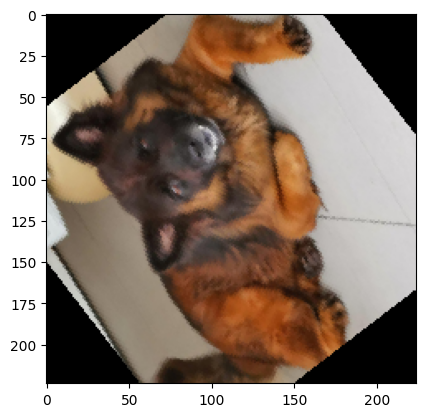

Epoch [3/5], Loss: 2.2821


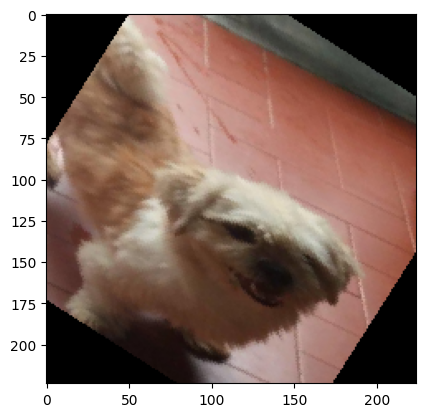

Epoch [4/5], Loss: 2.1165


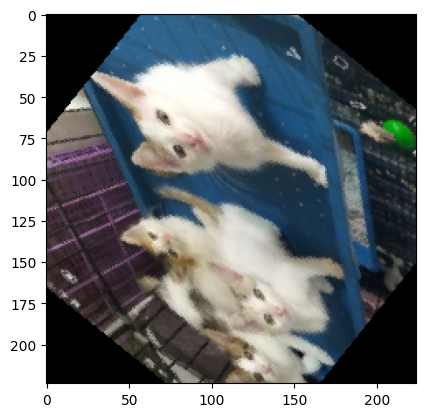

Epoch [5/5], Loss: 1.5388


In [48]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    idx = random.randint(0, images.size(0) - 1)
    plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
    plt.show()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    

# Test Model

In [49]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(len(image_paths), 100 * correct / total))

Accuracy of the network on the 100 train images: 26.0 %
